In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import models
import os
import cv2 as cv
import torch.optim as optim
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [ ]:
torch.cuda.get_device_name(0)

## Initialization

In [4]:
torch.manual_seed(42)
DATASET_PATH = "./data"
CHECKPOINT_PATH = "saved_models"
TRAINING_EPOCHS = 10

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True)
data_mean = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
data_std = (train_dataset.data / 255.0).std(axis=(0, 1, 2))

In [6]:
# Declare transformations
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ]
)

# No data augmentation for testing
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                       download=True, transform=train_transform)

val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                       download=True, transform=test_transform)

test_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False,
                                       download=True, transform=test_transform)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])


In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

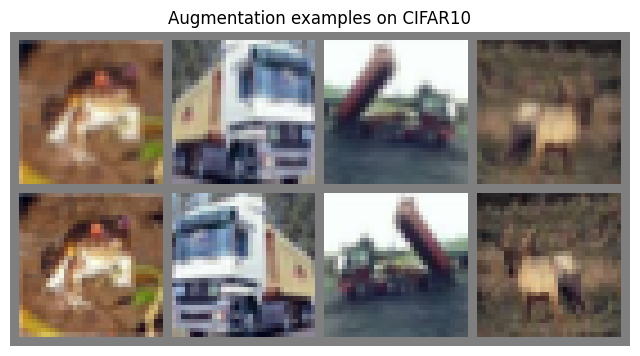

In [10]:
from PIL import Image

NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [11]:
data_iter = iter(val_loader)

In [12]:
images_pack, labels_pack = next(data_iter)

In [13]:
def evaluate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [15]:
def training(model, criterion, optimizer, train_loader, val_loader):
    best_loss = float('inf')
    best_model_state = None

    for epoch in range(TRAINING_EPOCHS):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0], data[1]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute validation loss
        val_loss = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model with validation loss:", best_loss)

## Linear Model Initialization

In [14]:
lin_model = models.LinearModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lin_model.parameters(), lr=0.001, momentum=0.9)

In [15]:
# Getting results before training
results = lin_model(images_pack) # Example code for mini-batches from a iter object.

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(5)))

Predicted:  (dog | cat) (cat | horse) (frog | cat) (plane | cat) (car | cat)


#### LM - Training

In [17]:
training(lin_model, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 1.8860215818100845, Validation Loss: 1.8377731263637542
Epoch 2, Training Loss: 1.8114801567164582, Validation Loss: 1.798380008339882
Epoch 3, Training Loss: 1.7950428265791674, Validation Loss: 1.7817098408937455
Epoch 4, Training Loss: 1.7861805716131487, Validation Loss: 1.7801198691129685
Epoch 5, Training Loss: 1.77776811673091, Validation Loss: 1.7945165514945984
Epoch 6, Training Loss: 1.7771709926447636, Validation Loss: 1.771570059657097
Epoch 7, Training Loss: 1.7727536302686078, Validation Loss: 1.7641219705343247
Epoch 8, Training Loss: 1.765810692072594, Validation Loss: 1.766156366467476
Epoch 9, Training Loss: 1.7633382835958757, Validation Loss: 1.763909450173378
Epoch 10, Training Loss: 1.7588845117818936, Validation Loss: 1.7635781735181808
Loaded best model with validation loss: 1.7635781735181808


#### LM - Save Trained Model

In [18]:
torch.save(lin_model.state_dict(), os.path.join(CHECKPOINT_PATH, "linear_model.pth"))

#### LM - Loading Trainer Model

In [15]:
lin_model = models.LinearModel()
lin_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "linear_model.pth")))

<All keys matched successfully>

#### LM - Getting some outputs

In [17]:
# results = lin_model(images[0].unsqueeze(0)) # Example code for 1 singular image given.
# _, prediction = torch.max(results, 1)
# print(classes[prediction])

results = lin_model(images_pack) # Example code for mini-batches from a iter object.

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (cat | cat) (dog | horse) (truck | cat) (cat | cat) (ship | cat) (truck | dog) (cat | cat) (frog | plane) (truck | horse) (dog | dog) (dog | bird) (ship | plane) (horse | plane) (horse | horse) (dog | cat) (plane | cat) (ship | plane) (frog | dog) (truck | cat) (car | plane)


## MLP - Initialization

In [16]:
mlp_model = models.MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.001, momentum=0.9)

In [19]:
# Get results before training
results = mlp_model(images_pack) # Example code for mini-batches from a iter object.

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (truck | cat) (truck | horse) (horse | cat) (ship | cat) (deer | cat) (deer | dog) (deer | cat) (deer | plane) (horse | horse) (ship | dog) (bird | bird) (deer | plane) (deer | plane) (deer | horse) (plane | cat) (horse | cat) (horse | plane) (truck | dog) (truck | cat) (horse | plane)


#### MLP - Training

In [23]:
training(mlp_model, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 1.9414629036205107, Validation Loss: 1.784571608901024
Epoch 2, Training Loss: 1.7243145154072688, Validation Loss: 1.6660382568836212
Epoch 3, Training Loss: 1.635675970645372, Validation Loss: 1.6016606241464615
Epoch 4, Training Loss: 1.5780114088303003, Validation Loss: 1.5510486572980882
Epoch 5, Training Loss: 1.5357231285497335, Validation Loss: 1.507715854048729
Epoch 6, Training Loss: 1.49422085251224, Validation Loss: 1.4754136145114898
Epoch 7, Training Loss: 1.4646608849875948, Validation Loss: 1.4359314084053039
Epoch 8, Training Loss: 1.434779809411095, Validation Loss: 1.4049866586923598
Epoch 9, Training Loss: 1.411291317382769, Validation Loss: 1.383003720641136
Epoch 10, Training Loss: 1.3906599300199765, Validation Loss: 1.3594055622816086
Loaded best model with validation loss: 1.3594055622816086


#### MLP - Save Trained Model

In [24]:
torch.save(mlp_model.state_dict(), os.path.join(CHECKPOINT_PATH, "mlp_model.pth"))

#### MLP - Load Trained Model

In [17]:
mlp_model = models.MLP()
mlp_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "mlp_model.pth")))

<All keys matched successfully>

In [21]:
results = mlp_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (dog | cat) (dog | horse) (truck | cat) (horse | cat) (ship | cat) (cat | dog) (car | cat) (frog | plane) (horse | horse) (dog | dog) (truck | bird) (plane | plane) (plane | plane) (horse | horse) (dog | cat) (plane | cat) (ship | plane) (cat | dog) (truck | cat) (car | plane)


## Convolutional Neural Network - Initialization

In [18]:
from models import ConvolutionNetwork
cnn_model = models.ConvolutionNetwork(in_chan=3, out_chan=3, kernel_size=(3, 3), stride=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

In [23]:
results = cnn_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (ship | cat) (plane | horse) (car | cat) (deer | cat) (ship | cat) (plane | dog) (ship | cat) (deer | plane) (deer | horse) (deer | dog) (deer | bird) (deer | plane) (plane | plane) (deer | horse) (deer | cat) (plane | cat) (deer | plane) (car | dog) (plane | cat) (deer | plane)


#### CNN - Training

In [29]:
training(cnn_model, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 2.206248024589995, Validation Loss: 2.070019927620888
Epoch 2, Training Loss: 1.9746951656124192, Validation Loss: 1.8823748052120208
Epoch 3, Training Loss: 1.800758635895884, Validation Loss: 1.7234477251768112
Epoch 4, Training Loss: 1.6618458857903113, Validation Loss: 1.6046024292707444
Epoch 5, Training Loss: 1.5608153567354903, Validation Loss: 1.5649426937103272
Epoch 6, Training Loss: 1.4966303986361904, Validation Loss: 1.4412071973085403
Epoch 7, Training Loss: 1.4438742185250306, Validation Loss: 1.4226932913064956
Epoch 8, Training Loss: 1.4015836311541392, Validation Loss: 1.3610921204090118
Epoch 9, Training Loss: 1.3706441485983694, Validation Loss: 1.3281258016824722
Epoch 10, Training Loss: 1.3383263366514462, Validation Loss: 1.3164673566818237
Loaded best model with validation loss: 1.3164673566818237


#### CNN - Save Trained Model

In [30]:
torch.save(cnn_model.state_dict(), os.path.join(CHECKPOINT_PATH, "cnn_model.pth"))

In [24]:
results = cnn_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (ship | cat) (plane | horse) (car | cat) (deer | cat) (ship | cat) (plane | dog) (ship | cat) (deer | plane) (deer | horse) (deer | dog) (deer | bird) (deer | plane) (plane | plane) (deer | horse) (deer | cat) (plane | cat) (deer | plane) (car | dog) (plane | cat) (deer | plane)


#### CNN - Load Trained Model

In [19]:
cnn_model = models.ConvolutionNetwork(in_chan=3, out_chan=3, kernel_size=(3, 3), stride=1)
cnn_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "cnn_model.pth")))

<All keys matched successfully>

## CNN with Batch - Initialization

In [20]:
cnn_batch_model = models.ConvolutionBatchNetwork(3, 3, 3, 1, "same", 32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_batch_model.parameters(), 0.001, 0.9)

In [27]:
results = cnn_batch_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (ship | cat) (bird | horse) (bird | cat) (bird | cat) (ship | cat) (truck | dog) (bird | cat) (bird | plane) (bird | horse) (bird | dog) (ship | bird) (bird | plane) (ship | plane) (bird | horse) (truck | cat) (bird | cat) (ship | plane) (bird | dog) (truck | cat) (bird | plane)


#### CNN Batch - Training

In [35]:
training(cnn_batch_model, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 1.8117419467692362, Validation Loss: 1.5479045540094376
Epoch 2, Training Loss: 1.4544453896009004, Validation Loss: 1.4148261964321136
Epoch 3, Training Loss: 1.3409727380486296, Validation Loss: 1.3363794833421707
Epoch 4, Training Loss: 1.2684898002874478, Validation Loss: 1.2310743629932404
Epoch 5, Training Loss: 1.2124424313547943, Validation Loss: 1.2067373767495155
Epoch 6, Training Loss: 1.166757396992795, Validation Loss: 1.1529369309544564
Epoch 7, Training Loss: 1.1329047138195092, Validation Loss: 1.1011588424444199
Epoch 8, Training Loss: 1.1010134603902486, Validation Loss: 1.1088471323251725
Epoch 9, Training Loss: 1.0720882391997553, Validation Loss: 1.0979873314499855
Epoch 10, Training Loss: 1.0540212538846878, Validation Loss: 1.0346444994211197
Loaded best model with validation loss: 1.0346444994211197


#### CNN Batch - Saving Trained Model

In [36]:
torch.save(cnn_batch_model.state_dict(), os.path.join(CHECKPOINT_PATH, "cnn_batch.pth"))

#### CNN Batch - Load Trained Model

In [21]:
cnn_batch_model = models.ConvolutionBatchNetwork(3, 3, 3, 1)
cnn_batch_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "cnn_batch.pth")))

<All keys matched successfully>

In [29]:
results = cnn_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (cat | cat) (dog | horse) (truck | cat) (frog | cat) (bird | cat) (cat | dog) (car | cat) (frog | plane) (truck | horse) (horse | dog) (truck | bird) (plane | plane) (plane | plane) (deer | horse) (cat | cat) (ship | cat) (ship | plane) (cat | dog) (truck | cat) (dog | plane)


## Resnet Initialization

In [22]:
import models
resnet_model = models.ResNet(3, 3, 3, 1, "same")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

In [31]:
results = resnet_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (deer | cat) (plane | horse) (deer | cat) (plane | cat) (plane | cat) (truck | dog) (deer | cat) (cat | plane) (frog | horse) (deer | dog) (deer | bird) (cat | plane) (deer | plane) (plane | horse) (dog | cat) (frog | cat) (deer | plane) (cat | dog) (frog | cat) (deer | plane)


#### Resnet Training

In [41]:
training(resnet_model, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 1.7070427684702425, Validation Loss: 1.506268858909607
Epoch 2, Training Loss: 1.416259672567036, Validation Loss: 1.358312550187111
Epoch 3, Training Loss: 1.3043836484267841, Validation Loss: 1.2852136611938476
Epoch 4, Training Loss: 1.2372000534989556, Validation Loss: 1.2446789354085923
Epoch 5, Training Loss: 1.187491393836475, Validation Loss: 1.1535304188728333
Epoch 6, Training Loss: 1.1535001042222026, Validation Loss: 1.2021968349814416
Epoch 7, Training Loss: 1.1328828667643402, Validation Loss: 1.0760079756379128
Epoch 8, Training Loss: 1.1089296281507552, Validation Loss: 1.0623898833990097
Epoch 9, Training Loss: 1.0911482959731011, Validation Loss: 1.1011653319001198
Epoch 10, Training Loss: 1.0716922622800213, Validation Loss: 1.0592619195580482
Loaded best model with validation loss: 1.0592619195580482


#### Resnet - Saving Trained Model

In [42]:
torch.save(resnet_model.state_dict(), os.path.join(CHECKPOINT_PATH, "resnet_model.pth"))

#### Resnet - Load Trained Model

In [23]:
resnet_model = models.ResNet(3, 3, 3, 1, "same")
resnet_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "resnet_model.pth")))

<All keys matched successfully>

In [33]:
results = resnet_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (dog | cat) (cat | horse) (plane | cat) (deer | cat) (deer | cat) (dog | dog) (car | cat) (frog | plane) (horse | horse) (dog | dog) (ship | bird) (plane | plane) (plane | plane) (horse | horse) (cat | cat) (cat | cat) (plane | plane) (cat | dog) (truck | cat) (bird | plane)


## Deep Resnet - Initialization

In [24]:
modif_res = models.ImprovedDeepResnet(3, 3, 3, 1, 1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modif_res.parameters(), lr=0.001, momentum=0.9)

Improved DeepResnet with more residual connections


In [20]:
training(modif_res, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 1.5207955164787097, Validation Loss: 1.2287500262260438
Epoch 2, Training Loss: 1.1359070291546336, Validation Loss: 1.0357946529984474
Epoch 3, Training Loss: 0.9860472556872245, Validation Loss: 0.967532454431057
Epoch 4, Training Loss: 0.8902461751234158, Validation Loss: 0.8864286795258522
Epoch 5, Training Loss: 0.823314256817527, Validation Loss: 0.8262899577617645
Epoch 6, Training Loss: 0.767208820394641, Validation Loss: 0.7172391235828399
Epoch 7, Training Loss: 0.7248924921380828, Validation Loss: 0.6558450162410736
Epoch 8, Training Loss: 0.681319013025686, Validation Loss: 0.6308825209736824
Epoch 9, Training Loss: 0.6514426451123339, Validation Loss: 0.6829239532351494
Epoch 10, Training Loss: 0.623323005488795, Validation Loss: 0.5494961895048618
Loaded best model with validation loss: 0.5494961895048618


In [35]:
results = modif_res(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (horse | cat) (dog | horse) (horse | cat) (car | cat) (horse | cat) (horse | dog) (horse | cat) (bird | plane) (frog | horse) (horse | dog) (bird | bird) (horse | plane) (frog | plane) (horse | horse) (bird | cat) (horse | cat) (car | plane) (frog | dog) (horse | cat) (bird | plane)


In [21]:
torch.save(modif_res.state_dict(), os.path.join(CHECKPOINT_PATH, "modif_res.pth"))

### Deep Resnet - Load Model

In [25]:
modif_res.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "modif_res.pth")))

<All keys matched successfully>

## Deep CNN - Initialization

In [26]:
modif_cnn = models.ModifiedDeepCNN(3, 3, 3, 1, 1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modif_cnn.parameters(), lr=0.001, momentum=0.9)

In [17]:
training(modif_cnn, criterion, optimizer, train_loader, val_loader)

Epoch 1, Training Loss: 1.529681740323363, Validation Loss: 1.3269953787326814
Epoch 2, Training Loss: 1.1339651684136132, Validation Loss: 1.0025365203619003
Epoch 3, Training Loss: 0.9788326921626034, Validation Loss: 0.8879674136638641
Epoch 4, Training Loss: 0.8786105780180363, Validation Loss: 0.7911751374602318
Epoch 5, Training Loss: 0.8049800985219472, Validation Loss: 0.7753568172454834
Epoch 6, Training Loss: 0.75024736606837, Validation Loss: 0.6604995280504227
Epoch 7, Training Loss: 0.7057675135950757, Validation Loss: 0.6441932961344718
Epoch 8, Training Loss: 0.6638007952786579, Validation Loss: 0.7074058540165424
Epoch 9, Training Loss: 0.6331077915990454, Validation Loss: 0.6378682434558869
Epoch 10, Training Loss: 0.6072842893097815, Validation Loss: 0.5464334525167942
Loaded best model with validation loss: 0.5464334525167942


In [38]:
results = modif_cnn(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'({classes[predictions[j]]} | {classes[labels_pack[j]]})'
                              for j in range(20)))

Predicted:  (horse | cat) (truck | horse) (truck | cat) (frog | cat) (frog | cat) (frog | dog) (plane | cat) (truck | plane) (horse | horse) (cat | dog) (plane | bird) (horse | plane) (truck | plane) (frog | horse) (frog | cat) (horse | cat) (frog | plane) (plane | dog) (horse | cat) (truck | plane)


In [22]:
torch.save(modif_cnn.state_dict(), os.path.join(CHECKPOINT_PATH, "modif_cnn.pth"))

### Deep CNN - Load Model

In [27]:
modif_cnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "modif_cnn.pth")))

<All keys matched successfully>

## STL10 - Initialization (Testing Only)

In [28]:
from torch.utils.data import DataLoader

DATASET_PATH_STL = "./data/stl10"

# Define STL-10 transformations (resize + normalize like CIFAR-10)
transform_stl = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load STL-10 test dataset
stl10_testset = torchvision.datasets.STL10(
    root=DATASET_PATH_STL, split="test", download=True, transform=transform_stl
)


In [29]:
# Create test DataLoader (same batch size, num_workers as CIFAR-10)
test_loader_stl = DataLoader(
    stl10_testset, batch_size=128, shuffle=False, drop_last=False, num_workers=4
)

# Check dataset size
print(f"STL-10 Test Dataset Size: {len(stl10_testset)}")

STL-10 Test Dataset Size: 8000


## Accuracy

In [42]:
def model_acc(model_type, data_test_loader):

    # Set model to evaluation mode
    model_type.eval()

    # Ensure computations do not track gradients
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_type.to(device)  # Move model to the same device as test data

    with torch.no_grad():  # Disable gradient computation
        for data in data_test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move to same device

            # Forward pass
            outputs = model_type(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    # model_type.__class__.__name__ to get model name
    print(f'Accuracy of the network on the {len(data_test_loader.dataset)} test images ({model_type.__class__.__name__}): {accuracy:.2f}%')

## Accuracy CIFAR-10 - 10 epochs

### Lin Accuracy

In [43]:
model_acc(lin_model, test_loader)

Accuracy of the network on the 10000 test images (LinearModel): 40.13%


### MLP Accuracy

In [44]:
model_acc(mlp_model, test_loader)

Accuracy of the network on the 10000 test images (MLP): 52.31%


### CNN Accuracy

In [45]:
model_acc(cnn_model, test_loader)

Accuracy of the network on the 10000 test images (ConvolutionNetwork): 53.55%


### CNN With Batch Accuracy

In [46]:
model_acc(cnn_batch_model, test_loader)

Accuracy of the network on the 10000 test images (ConvolutionBatchNetwork): 64.93%


### Resnet Accuracy

In [47]:
model_acc(resnet_model, test_loader)

Accuracy of the network on the 10000 test images (ResNet): 64.86%


### Deep CNN Accuracy

In [48]:
model_acc(modif_cnn, test_loader)

Accuracy of the network on the 10000 test images (ModifiedDeepCNN): 78.78%


### Deep Resnet Accuracy

In [49]:
model_acc(modif_res, test_loader)

Accuracy of the network on the 10000 test images (ImprovedDeepResnet): 78.49%


## CIFAR-10 - 20 Epochs

### Loading 20 Epoch Models

In [32]:
# 20 Epoch Checkpoint
CHECKPOINT_PATH_20_EPOCHS = "saved_models_20E"

# Linear
lin_model_20 = models.LinearModel()
lin_model_20.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH_20_EPOCHS, "linear_model.pth")))

# MLP
mlp_model_20 = models.MLP()
mlp_model_20.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH_20_EPOCHS, "mlp_model.pth")))

# CNN
cnn_model_20 = models.ConvolutionNetwork(in_chan=3, out_chan=3, kernel_size=(3, 3), stride=1)
cnn_model_20.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH_20_EPOCHS, "cnn_model.pth")))

# CNN Batch
cnn_batch_model_20 = models.ConvolutionBatchNetwork(3, 3, 3, 1)
cnn_batch_model_20.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH_20_EPOCHS, "cnn_batch.pth")))

# Resnet
resnet_model_20 = models.ResNet(3, 3, 3, 1, "same")
resnet_model_20.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH_20_EPOCHS, "resnet_model.pth")))

<All keys matched successfully>

### Accuracy 20 Epochs

### Lin Accuracy

In [50]:
model_acc(lin_model_20, test_loader)

Accuracy of the network on the 10000 test images (LinearModel): 40.10%


### MLP Accuracy

In [51]:
model_acc(mlp_model_20, test_loader)

Accuracy of the network on the 10000 test images (MLP): 56.22%


### CNN Accuracy

In [52]:
model_acc(cnn_model_20, test_loader)

Accuracy of the network on the 10000 test images (ConvolutionNetwork): 62.49%


### CNN With Batch Accuracy

In [53]:
model_acc(cnn_batch_model_20, test_loader)

Accuracy of the network on the 10000 test images (ConvolutionBatchNetwork): 67.57%


### Resnet Accuracy

In [54]:
model_acc(resnet_model_20, test_loader)

Accuracy of the network on the 10000 test images (ResNet): 66.75%


### Accuracy For Each Class 

In [33]:
def class_wise_acc(model_type, data_test_loader, dataset='cifar10'):

    cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    
    stl10_classes = ['plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
    
    if dataset.lower() == 'stl10':
        classes = stl10_classes
    else:
        classes = cifar10_classes

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in data_test_loader:
            images, labels = data
            outputs = model_type(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    print(f"{model_type.__class__.__name__}:\n")

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

#### Classwise Accuracy for 10 Epochs - CIFAR-10

In [35]:
class_wise_acc(lin_model, test_loader)

LinearModel:

Accuracy for class: plane is 41.5 %
Accuracy for class: car   is 43.6 %
Accuracy for class: bird  is 28.1 %
Accuracy for class: cat   is 27.2 %
Accuracy for class: deer  is 31.6 %
Accuracy for class: dog   is 30.7 %
Accuracy for class: frog  is 47.2 %
Accuracy for class: horse is 43.8 %
Accuracy for class: ship  is 59.4 %
Accuracy for class: truck is 48.2 %


In [36]:
class_wise_acc(mlp_model, test_loader)

MLP:

Accuracy for class: plane is 55.1 %
Accuracy for class: car   is 69.5 %
Accuracy for class: bird  is 39.7 %
Accuracy for class: cat   is 32.7 %
Accuracy for class: deer  is 39.8 %
Accuracy for class: dog   is 38.9 %
Accuracy for class: frog  is 62.8 %
Accuracy for class: horse is 59.8 %
Accuracy for class: ship  is 67.2 %
Accuracy for class: truck is 57.6 %


In [37]:
class_wise_acc(cnn_model, test_loader)

ConvolutionNetwork:

Accuracy for class: plane is 61.0 %
Accuracy for class: car   is 73.2 %
Accuracy for class: bird  is 27.7 %
Accuracy for class: cat   is 30.1 %
Accuracy for class: deer  is 38.3 %
Accuracy for class: dog   is 47.0 %
Accuracy for class: frog  is 69.3 %
Accuracy for class: horse is 64.1 %
Accuracy for class: ship  is 59.2 %
Accuracy for class: truck is 65.6 %


In [38]:
class_wise_acc(cnn_batch_model, test_loader)

ConvolutionBatchNetwork:

Accuracy for class: plane is 68.0 %
Accuracy for class: car   is 82.2 %
Accuracy for class: bird  is 46.4 %
Accuracy for class: cat   is 34.2 %
Accuracy for class: deer  is 52.2 %
Accuracy for class: dog   is 64.4 %
Accuracy for class: frog  is 76.0 %
Accuracy for class: horse is 75.8 %
Accuracy for class: ship  is 78.8 %
Accuracy for class: truck is 68.8 %


In [39]:
class_wise_acc(resnet_model, test_loader)

ResNet:

Accuracy for class: plane is 68.0 %
Accuracy for class: car   is 79.7 %
Accuracy for class: bird  is 50.8 %
Accuracy for class: cat   is 38.5 %
Accuracy for class: deer  is 56.5 %
Accuracy for class: dog   is 54.4 %
Accuracy for class: frog  is 80.3 %
Accuracy for class: horse is 70.9 %
Accuracy for class: ship  is 80.0 %
Accuracy for class: truck is 67.1 %


In [40]:
class_wise_acc(modif_cnn, test_loader)

ModifiedDeepCNN:

Accuracy for class: plane is 82.4 %
Accuracy for class: car   is 86.6 %
Accuracy for class: bird  is 66.0 %
Accuracy for class: cat   is 62.5 %
Accuracy for class: deer  is 77.2 %
Accuracy for class: dog   is 66.0 %
Accuracy for class: frog  is 86.5 %
Accuracy for class: horse is 77.2 %
Accuracy for class: ship  is 89.2 %
Accuracy for class: truck is 86.1 %


In [41]:
class_wise_acc(modif_res, test_loader)

ImprovedDeepResnet:

Accuracy for class: plane is 77.2 %
Accuracy for class: car   is 91.2 %
Accuracy for class: bird  is 69.4 %
Accuracy for class: cat   is 60.2 %
Accuracy for class: deer  is 69.9 %
Accuracy for class: dog   is 73.3 %
Accuracy for class: frog  is 84.7 %
Accuracy for class: horse is 82.8 %
Accuracy for class: ship  is 87.8 %
Accuracy for class: truck is 81.3 %


#### Classwise Accuracy for 20 Epochs

In [55]:
class_wise_acc(lin_model_20, test_loader)

LinearModel:

Accuracy for class: plane is 53.5 %
Accuracy for class: car   is 43.9 %
Accuracy for class: bird  is 23.5 %
Accuracy for class: cat   is 23.4 %
Accuracy for class: deer  is 33.4 %
Accuracy for class: dog   is 31.8 %
Accuracy for class: frog  is 47.5 %
Accuracy for class: horse is 41.1 %
Accuracy for class: ship  is 59.2 %
Accuracy for class: truck is 43.7 %


In [56]:
class_wise_acc(mlp_model_20, test_loader)

MLP:

Accuracy for class: plane is 62.6 %
Accuracy for class: car   is 64.2 %
Accuracy for class: bird  is 45.3 %
Accuracy for class: cat   is 31.5 %
Accuracy for class: deer  is 49.0 %
Accuracy for class: dog   is 46.8 %
Accuracy for class: frog  is 67.0 %
Accuracy for class: horse is 64.2 %
Accuracy for class: ship  is 64.4 %
Accuracy for class: truck is 67.2 %


In [57]:
class_wise_acc(cnn_model_20, test_loader)

ConvolutionNetwork:

Accuracy for class: plane is 68.0 %
Accuracy for class: car   is 76.8 %
Accuracy for class: bird  is 37.8 %
Accuracy for class: cat   is 32.1 %
Accuracy for class: deer  is 45.1 %
Accuracy for class: dog   is 59.2 %
Accuracy for class: frog  is 75.1 %
Accuracy for class: horse is 75.4 %
Accuracy for class: ship  is 78.5 %
Accuracy for class: truck is 76.9 %


In [58]:
class_wise_acc(cnn_batch_model_20, test_loader)

ConvolutionBatchNetwork:

Accuracy for class: plane is 75.9 %
Accuracy for class: car   is 86.1 %
Accuracy for class: bird  is 47.3 %
Accuracy for class: cat   is 37.9 %
Accuracy for class: deer  is 51.1 %
Accuracy for class: dog   is 58.0 %
Accuracy for class: frog  is 90.0 %
Accuracy for class: horse is 82.8 %
Accuracy for class: ship  is 72.1 %
Accuracy for class: truck is 74.5 %


In [59]:
class_wise_acc(resnet_model_20, test_loader)

ResNet:

Accuracy for class: plane is 73.3 %
Accuracy for class: car   is 82.5 %
Accuracy for class: bird  is 49.2 %
Accuracy for class: cat   is 27.8 %
Accuracy for class: deer  is 63.5 %
Accuracy for class: dog   is 56.1 %
Accuracy for class: frog  is 88.6 %
Accuracy for class: horse is 74.2 %
Accuracy for class: ship  is 82.6 %
Accuracy for class: truck is 69.7 %


## Accuracy STL10 - 10 Epochs

### Lin Accuracy

In [74]:
model_acc(lin_model, test_loader_stl)

Accuracy of the network on the 8000 test images (LinearModel): 18.41%


### MLP Accuracy

In [75]:
model_acc(mlp_model, test_loader_stl)

Accuracy of the network on the 8000 test images (MLP): 20.96%


### CNN Accuracy

In [77]:
model_acc(cnn_model, test_loader_stl)

Accuracy of the network on the 8000 test images (ConvolutionNetwork): 18.01%


### CNN With Batch Accuracy

In [63]:
model_acc(cnn_batch_model, test_loader_stl)

Accuracy of the network on the 8000 test images (ConvolutionBatchNetwork): 22.98%


### Resnet Accuracy

In [64]:
model_acc(resnet_model, test_loader_stl)

Accuracy of the network on the 8000 test images (ResNet): 21.60%


### Deep CNN Accuracy

In [65]:
model_acc(modif_cnn, test_loader_stl)

Accuracy of the network on the 8000 test images (ModifiedDeepCNN): 26.30%


### Deep Resnet Accuracy

In [66]:
model_acc(modif_res, test_loader_stl)

Accuracy of the network on the 8000 test images (ImprovedDeepResnet): 28.34%


### Accuracy For Each Class - STL10 - 10 Epochs

In [67]:
class_wise_acc(lin_model, test_loader_stl, "stl10")

LinearModel:

Accuracy for class: plane is 30.0 %
Accuracy for class: bird  is 2.0 %
Accuracy for class: car   is 31.2 %
Accuracy for class: cat   is 30.1 %
Accuracy for class: deer  is 29.6 %
Accuracy for class: dog   is 13.9 %
Accuracy for class: horse is 11.8 %
Accuracy for class: monkey is 2.4 %
Accuracy for class: ship  is 21.9 %
Accuracy for class: truck is 11.2 %


In [68]:
class_wise_acc(mlp_model, test_loader_stl, "stl10")

MLP:

Accuracy for class: plane is 42.6 %
Accuracy for class: bird  is 1.0 %
Accuracy for class: car   is 12.1 %
Accuracy for class: cat   is 9.2 %
Accuracy for class: deer  is 53.6 %
Accuracy for class: dog   is 13.4 %
Accuracy for class: horse is 15.2 %
Accuracy for class: monkey is 4.8 %
Accuracy for class: ship  is 46.4 %
Accuracy for class: truck is 11.2 %


In [69]:
class_wise_acc(cnn_model, test_loader_stl, "stl10")

ConvolutionNetwork:

Accuracy for class: plane is 35.9 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: car   is 15.0 %
Accuracy for class: cat   is 3.6 %
Accuracy for class: deer  is 73.5 %
Accuracy for class: dog   is 5.5 %
Accuracy for class: horse is 13.2 %
Accuracy for class: monkey is 2.5 %
Accuracy for class: ship  is 25.6 %
Accuracy for class: truck is 5.2 %


In [70]:
class_wise_acc(cnn_batch_model, test_loader_stl, "stl10")

ConvolutionBatchNetwork:

Accuracy for class: plane is 51.6 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: car   is 30.6 %
Accuracy for class: cat   is 10.8 %
Accuracy for class: deer  is 65.0 %
Accuracy for class: dog   is 10.9 %
Accuracy for class: horse is 1.0 %
Accuracy for class: monkey is 0.5 %
Accuracy for class: ship  is 54.2 %
Accuracy for class: truck is 5.1 %


In [71]:
class_wise_acc(resnet_model, test_loader_stl, "stl10")

ResNet:

Accuracy for class: plane is 49.8 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: car   is 18.6 %
Accuracy for class: cat   is 8.5 %
Accuracy for class: deer  is 74.1 %
Accuracy for class: dog   is 6.5 %
Accuracy for class: horse is 1.1 %
Accuracy for class: monkey is 0.9 %
Accuracy for class: ship  is 51.6 %
Accuracy for class: truck is 4.9 %


In [72]:
class_wise_acc(modif_cnn, test_loader_stl, "stl10")

ModifiedDeepCNN:

Accuracy for class: plane is 55.4 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: car   is 12.6 %
Accuracy for class: cat   is 23.4 %
Accuracy for class: deer  is 86.8 %
Accuracy for class: dog   is 5.2 %
Accuracy for class: horse is 2.4 %
Accuracy for class: monkey is 0.4 %
Accuracy for class: ship  is 64.0 %
Accuracy for class: truck is 12.9 %


In [73]:
class_wise_acc(modif_res, test_loader_stl, "stl10")

ImprovedDeepResnet:

Accuracy for class: plane is 61.2 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: car   is 13.1 %
Accuracy for class: cat   is 19.6 %
Accuracy for class: deer  is 81.2 %
Accuracy for class: dog   is 15.1 %
Accuracy for class: horse is 4.5 %
Accuracy for class: monkey is 0.2 %
Accuracy for class: ship  is 62.9 %
Accuracy for class: truck is 25.4 %
